# Реализация R-CNN
Реализовать детектирование объектов с помощью метода R-CNN. Взять датасет MNIST и создать на его основе детекционный датасет, который будет сосотять из изображений, на которых будет располагаться произвольное количество цифр из MNIST.

Для работы R-CNN нам потребуются две состовляющее: Region Proposals (пропозалы) и классификатор. Для простоты демонстрации в качестве пропозалов использовать сгенерированные "фейковые" пропозалы, полученные по известным ground-truth боксам. В идеале за их создание должен был бы отвечать какой-то сторонний алгоритм.

В качестве классификатора взять обычную CNN, обученную на классификациию цифр. Однако, обучать такую модель нужно на данных, соответствующих нашему детекционному датасету. Поэтому нам дополнительно придётся создать классификационный датасет, состоящий из вырезанных кусочков изображений детекционного датасета. Исходный датасет MNIST не подойдет, так как боксы могут быть различных размеров, а также нужно будет добавить класс фон. Тем более в реальном приложении при постановке задачи нам был бы дан именно детекционный датасет.

### Загрузка необходимых библиотек
Здесь мы загружаем различне библиотеки, включая TensoFlow.


In [1]:
import random
import numpy as np
import skimage.filters
from skimage.transform import resize

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.6.0


# Подготовка датасета

### Загрузка оригинального датасета MNIST
Загружаем датасет MNIST (train и test) и приводим данные к удобному формату:
* Размер: (N, 28, 28, 1), где N - количество образцов в подвыборке
* Значения интесивности: float32 в диапазоне [0, 1]

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


### Подготовка фона для для новых изображений

Синтезировать новый датасет, который будет состоять из изображений бОльшего размера, чем 28x28. На каждом таком новом изображении будет находиться несколько цифр из MNIST, которые нам нужно будет задетектировать.

Фоном будет выступать сгенерированый шум. Для синтеза такого фона сгенерируем случайный равномерный шум и "размоем" его с помощью фильтра Гаусса. Сгенерировано одно большое изображение 1000x1000 из которого будем случайным образом брать кусочки для фона очрендного образца.



In [3]:
bg_source = np.random.rand(1000, 1000, 1).astype(np.float32)
bg_source = skimage.filters.gaussian(bg_source, 4)
bg_source = (bg_source - np.min(bg_source))/(np.max(bg_source) - np.min(bg_source))
bg_source = np.clip(bg_source, 0, 1)

### Функция генерации датасета для задачи детектирования объектов
Реализовать функцию `gen_od_ds`, в которую передается подвыборка (train или test) картинок из MNIST (x) и правильных классификационных ответов (y). Задача функции сгенерировать новый датасет, состоящий из картинок размера `new_size`. Для создания каждой новой картинки берём случайный кусочек фона из bg_source, а затем поместим несколько цифр из MNIST на случайные места в новой картинке. Количество цифр тоже выбирается случайно.

В качестве Ground-Truth данных для одного образца будем использовать список боксов с правильными классами. Один бокс будет представлять собой список из 5 элеменов `[ys, ry, rx, rh, rw]`: метка класса, и четыре числа, задающих бокс (нормализованные координаты относительно размера нового изображения).

In [4]:
def gen_od_ds(x, y, bg_source, new_size, num_samples, max_num_objects):
    x_new = np.zeros((num_samples, new_size[0], new_size[1], 1), dtype=np.float32)
    y_new = []
    
    rh = float(x.shape[1]) / new_size[0]
    rw = float(x.shape[2]) / new_size[1]
    
    for i in range(num_samples):
        oh = random.randint(0, bg_source.shape[0] - new_size[0])
        ow = random.randint(0, bg_source.shape[1] - new_size[1])
        x_new[i] = bg_source[oh:oh+new_size[0], ow:ow+new_size[1], :]
        num_of_objects = random.randint(1, max_num_objects)
        y_new.append([])
        for _ in range(num_of_objects):
            sample_idx = random.randint(0, x.shape[0]-1)
            xs = x[sample_idx]
            ys = y[sample_idx]
            ofs = (random.randint(0, x_new[i].shape[0]-xs.shape[0]),
                   random.randint(0, x_new[i].shape[1]-xs.shape[1]))
            x_new[i][ofs[0]:ofs[0]+xs.shape[0], ofs[1]:ofs[1]+xs.shape[1], :] += xs
            ry = float(ofs[0]) / new_size[0]
            rx = float(ofs[1]) / new_size[1]
            y_new[-1].append([ys, ry, rx, rh, rw])
            
        x_new[i] = np.clip(x_new[i], 0.0, 1.0)
        
    return x_new, y_new

### Генерация датасета для детектирования объектов
Сгенерировать детекционный датасет (train и test). Размер новых картинок (`new_size`) возьмем 128x128

In [5]:
new_size = (128, 128)
train_num_samples = 60000
test_num_samples = 10000
max_num_objects = 3 # максимальное кол-во цифр на одном изображении

train_x_det, train_y_det = gen_od_ds(train_x, train_y, bg_source, new_size, train_num_samples, max_num_objects)
test_x_det, test_y_det = gen_od_ds(test_x, test_y, bg_source, new_size, test_num_samples, max_num_objects)

print(train_x.shape)
print(len(train_y))
print(test_x.shape)
print(len(test_y))

(60000, 28, 28, 1)
60000
(10000, 28, 28, 1)
10000


### Функция для отображения детекций
Реализовать функцию, которая по входной картинке и предсказанию (ground-truth или выход модели) визуализирует это предсказание на картинке: все найденные боксы и соответствующие им классы.

In [6]:
def show_prediction(img, preds):
    import matplotlib.patches as patches
    
    fig,ax = plt.subplots(1)
    ax.imshow(img[...,0], 'gray', vmin=0, vmax=1,)
    
    for pred in preds:

        pred_cls = pred[0]
        ry, rx, rh, rw = pred[1:]
        
        box_y = int(ry * img.shape[0])
        box_x = int(rx * img.shape[1])
        box_w = int(rw * img.shape[1])
        box_h = int(rh * img.shape[0])

        rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        rect = patches.Rectangle((box_x, box_y), 10, -10, linewidth=1, edgecolor='r', facecolor='r')
        ax.add_patch(rect)
        ax.text(box_x+4, box_y-2, pred_cls)

### Визуализация Ground-Truth образца

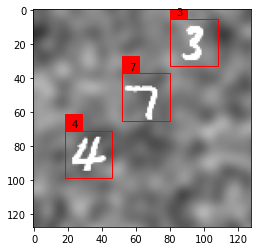

In [7]:
idx = 0
show_prediction(train_x_det[idx], train_y_det[idx])

# Детектирование объектов с помощью R-CNN

### Функция для генерации пропозалов
Для работы метода R-CNN нужны пропозалы. В классическом подходе их должен генерировать некоторый сторонний алгоритм Region Proposals. Однако, такие алгоритмы могут быть достаточно сложными, а в текущем уроке наша основная цель -- разобраться со второй частью R-CNN пайплайна: детектирование объекта при условии наличия пропозалов.

Поэтому (в демонстрационных целях) реализовать функцию `gen_fake_proposals`, задача которой имитировать поведение некоторого алгоритма Region Proposals. На входе у нас есть набор картинок (x_det), а на выходе набор пропозалов для каждой картинки. Один пропозал характеризуется четырьмя числами `[ry, rx, rh, rw]` -- нормализованные координаты бокса.

Для каждой картики список пропозалов будет состоять из ground-truth боксов (которые необходимо передать на вход в эту функцию) и нескильких случайно сгенерированных новых пропозалов. В реальном методе Region Proposals все пропозалы, должны генерироваться по картинке.

In [8]:
def gen_fake_proposals(x_det, y_det, ori_shape, num_proposals):
    all_proposals = []
    for boxes in y_det:
        proposals = []
        for box in boxes:
            proposals.append(box[1:])
        extra_prop_num = num_proposals - len(proposals)
        for _ in range(extra_prop_num):
            proposal_shape = (ori_shape[0] + random.randint(-8, 8), 
                              ori_shape[1] + random.randint(-8, 8))
            ofs = (random.randint(0, x_det.shape[1]-proposal_shape[0]),
                   random.randint(0, x_det.shape[2]-proposal_shape[1]))

            rh = float(proposal_shape[0]) / x_det.shape[1]
            rw = float(proposal_shape[1]) / x_det.shape[2]            
            ry = float(ofs[0]) / x_det.shape[1]
            rx = float(ofs[1]) / x_det.shape[2]
            proposals.append([ry, rx, rh, rw])
        
        random.shuffle(proposals)                              
        all_proposals.append(proposals)
        
    return all_proposals

### Генерация пропозалов
Сгенерируем пропозалы для тестовых изображений детекционного датасета.

`ori_shape` - базовый размер пропозала. Новые сгенерированные пропозалы будет меньше или больше этого размера на случайную величину.

`num_proposals` - обычно методы Region Proposals имеют входным параметром "сколкьо пропозалов выдать на выход". В случае нашей `gen_fake_proposals` мы просто выдаём все ground-turth боксы и оставшееся число случайных пропозалов, чтобы сумма была равна `num_proposals`

Посмотрим, что получилось: для нулевой картики из датасета у нас 8 пропозалов, каждый является списком из 4 элементов.

In [9]:
ori_shape = (28, 28)
num_proposals = 8 # количество пропозалов на одну картинку

test_proposals = gen_fake_proposals(test_x_det, test_y_det, ori_shape, num_proposals)

for p in test_proposals[0]:
    print(p)

[0.0703125, 0.046875, 0.2109375, 0.171875]
[0.3046875, 0.1640625, 0.1875, 0.1640625]
[0.671875, 0.296875, 0.21875, 0.21875]
[0.015625, 0.703125, 0.15625, 0.2421875]
[0.515625, 0.1640625, 0.2109375, 0.265625]
[0.5546875, 0.234375, 0.2109375, 0.265625]
[0.0546875, 0.125, 0.2734375, 0.1796875]
[0.7265625, 0.4921875, 0.2578125, 0.1953125]


### Функция для визуализации пропозалов
Вищуализация пропозалов для одного изображения

In [10]:
def show_proposals(img, proposals):
    import matplotlib.patches as patches
    
    fig,ax = plt.subplots(1)
    ax.imshow(img[...,0], 'gray', vmin=0, vmax=1,)
    
    for proposal in proposals:

        ry, rx, rh, rw = proposal
        
        box_y = int(round(ry * img.shape[0]))
        box_x = int(round(rx * img.shape[1]))
        box_w = int(round(rw * img.shape[1]))
        box_h = int(round(rh * img.shape[0]))

        rect = patches.Rectangle((box_x, box_y), box_w, box_h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

### Пример визуализации пропозалов для одного изображения

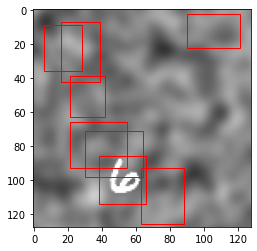

In [11]:
idx = 0
show_proposals(test_x_det[idx], test_proposals[idx])

### Функция для создания обучающего датасета для R-CNN
Внутри R-CNN метода работает обычная классификационная сеть, поэтому для нее нужно сгенерировать классификационный датасет по имеющемуся детекционному датасету. 

Создадим функцию, у которой на входе будет детекционный датасет `(x_det, y_det)`, а на выходе сгенерированный классификационный `(x_cls, y_cls)`

Несмотря на то, что в детекционном датасете все объекты у нас фиксированного размера, в реальном приложении они могут быть разного размера и соотношения сторон. В R-CNN вход в классификационную сеть, как правило, имеет фиксированный размер. Поэтмоу все объекты из детекционного датасета мы преобразуем к этому фиксированному размеру `inp_size` (размер входа в классификатор).

Кроме того, нам понадобятся экзамепляры для класса "фон" (в количестве `bg_samples_num`). В идеале надо сэмплировать такие экземпляры из тех же изображений входного датасета, и брать те, которые "не очень сильно" пересекаются или вообще не пересекаются с реальными объектами. Более формально: если относительная площадь пересечения бокса "фона" и бокса объекта меньше некоторого порога. Но в даном примере мы упростим себе задачу и будем сэмплировать примеры класса "фон" из изображения `bg_source`, на котором не содержатся никакие цифры.

In [12]:
def gen_classification_ds(x_det, y_det, inp_size, bg_source, bg_samples_num):
    imgs = []
    labels = []
    for i in range(len(x_det)):
        if i % 10000 == 0:
            print('[{} / {}]'.format(i, len(x_det)))
        img = x_det[i]
        for box in y_det[i]:
            pred_cls = box[0]
            ry, rx, rh, rw = box[1:]

            box_y = int(round(ry * img.shape[0]))
            box_x = int(round(rx * img.shape[1]))
            box_w = int(round(rw * img.shape[1]))
            box_h = int(round(rh * img.shape[0]))
            img_sub = img[box_y:box_y+box_h, box_x:box_x+box_w, :]     
            if img_sub.shape[0] == inp_size[0] and img_sub.shape[1] == inp_size[1]:
                img_inp = img_sub
            else:
                img_inp = resize(img_sub, (inp_size[0], inp_size[1]), 
                    order=3, mode='reflect', anti_aliasing=True)
            imgs.append(img_inp)
            labels.append(pred_cls)
            
    for i in range(bg_samples_num):
        if i % 10000 == 0:
            print('[{} / {}]'.format(i, bg_samples_num))
        ofs = (random.randint(0, bg_source.shape[0]-inp_size[0]),
               random.randint(0, bg_source.shape[1]-inp_size[1]))
        imgs.append(bg_source[ofs[0]:ofs[0]+inp_size[0], ofs[1]:ofs[1]+inp_size[1], :])
        labels.append(10) # bg
            
    x_cls = np.stack(imgs)
    y_cls = np.stack(labels)
    return x_cls, y_cls

### Создание обучающего датасета для R-CNN
Сгенерируем классификационный обучающий датасет для классификатора, который затем будем использовать в R-CNN.


In [13]:
bg_samples_num = 100000 # Количество образцов класса "фон"
inp_size = (28, 28) # Размер входа в нейросеть

train_x_cls, train_y_cls = gen_classification_ds(train_x_det, train_y_det, inp_size, bg_source, bg_samples_num)

[0 / 60000]
[10000 / 60000]
[20000 / 60000]
[30000 / 60000]
[40000 / 60000]
[50000 / 60000]
[0 / 100000]
[10000 / 100000]
[20000 / 100000]
[30000 / 100000]
[40000 / 100000]
[50000 / 100000]
[60000 / 100000]
[70000 / 100000]
[80000 / 100000]
[90000 / 100000]


### Создание классификационной модели
Для работы R-CNN нам нужна обычная классификационная модель (CNN), которая будет классифицировать пропозалы.

**[Задание 1]** Вопрос: Сколько выходных нейронов будет у такой модели?

**[Задание 2]** Реализуйте классификационную модель для R-CNN (создайте объект `model)`. По сути, это должен быть обычный классификатор, на вход в который при инференсе подаётся пропозал, предварительно трансформаированный до нужного фиксированного размера. Транформация пропозала будет производиться за пределами нейросети.

In [14]:
NUM_CLASSES = 11

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

### Обучение классификационной модели

**[ЗАДАНИЕ 3]** Реализуйте пайплайн обучения описанной выше модели `model`, как это делалось для других задач обучения в TensorFlow. Используйте созданный выше классификационный датасет (`train_x_cls` и `train_y_cls`) в качестве обучающего датасета. Постройте график зависимости лосса от эпохи.

Epoch 1/5
3438/3438 [==============================] - 28s 8ms/step - loss: 0.0149 - accuracy: 0.9952
Epoch 2/5
3438/3438 [==============================] - 27s 8ms/step - loss: 0.0101 - accuracy: 0.9966
Epoch 3/5
3438/3438 [==============================] - 27s 8ms/step - loss: 0.0083 - accuracy: 0.9973
Epoch 4/5
3438/3438 [==============================] - 27s 8ms/step - loss: 0.0065 - accuracy: 0.9979
Epoch 5/5
6876/6876 [==============================] - 28s 4ms/step - loss: 0.0022 - accuracy: 0.9993


[0.0021903098095208406, 0.9992773532867432]

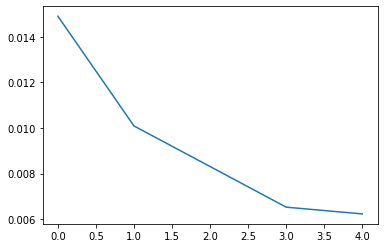

In [16]:
NUM_EPOCHS = 5
BATCH_SIZE = 64

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

hist = model.fit(train_x_cls, train_y_cls, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

plt.plot(hist.history['loss'])

model.evaluate(train_x_cls, train_y_cls)

### Пример получения входа в классификатор по пропозалу
В этом примере кода мы получим входное изображения для классификатора, соответствующее некоторому одному пропазалу на некоторой картинке из нашего детекционного датасета. 

После того, как мы выбрали некий `proposal` (4 числа), нам надо получить соответствующий кусочек детекционной картинки, который будем позже подавать на вход в классификатор. Для этого сначала трансформируем относительные координаты бокса в абсолютные:

`([ry, rx, rw, rh] -> [box_y, box_x, box_w, box_h])`

Затем вырежем соответствующий кусочек из большой картинки и трансформируем его до желаемого размера (`inp_size` -- размер входа в классификатор) с помощью `resize`.
Визуализируем все пропозалы для данной картинки и вырезанный трансосформированный пропозал.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f25f6a45490>)

<Figure size 432x288 with 0 Axes>

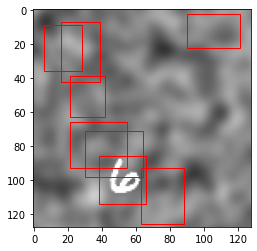

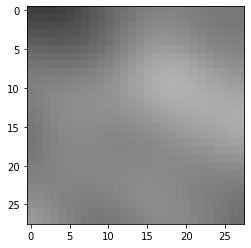

In [17]:
inp_size = (28, 28)

idx = 0
img = test_x_det[idx]
proposals_img = test_proposals[idx]
proposal = proposals_img[0]

ry, rx, rh, rw = proposal        
box_y = int(round(ry * img.shape[0]))
box_x = int(round(rx * img.shape[1]))
box_w = int(round(rw * img.shape[1]))
box_h = int(round(rh * img.shape[0]))
img_sub = img[box_y:box_y+box_h, box_x:box_x+box_w, :]     
img_inp = resize(img_sub, (inp_size[0], inp_size[1]), 
    order=3, mode='reflect', anti_aliasing=True)

# Все пропозалы
plt.figure(), show_proposals(img, proposals_img)

# Вырезанный и трансформированный пропозал
plt.figure(), plt.imshow(img_inp[...,0], 'gray', vmin=0, vmax=1,)

### Функция R-CNN
В R-CNN детектирование объектов производится следующим образом: для всех пропозалов на картинке мы запускаем классификатор. Если классификатор выдаёт класс "фон", значит в этом пропозале нет объекта и мы его отбрасываем. Если классификатор выдаёт другой класс, значит мы задетектировали объект -- добавляем его координаты и метку класса в список детекций.

В идеале в R-CNN должен работать не только классификатор, но и регрессор, который немного поправит координаты бокса, пришедшие из пропозала. Но в данном примере опустить данную часть для простоты.

**[ЗАДАНИЕ]** Реализовать функцию `rcnn_prediction`, которая принимает на вход изображение, список пропозалов и размер входа в классификатор, и выдаёт список задетектированных объектов. Каждый задетектированный объект пусть задаётся списком `[метка класса, ry, rx, rh, rw]`, где `ry, rx, rh, rw` - относительные координаты бокса задетектированного объекта (по аналогии с тем, как выглядит Ground-Truth в детекционном датасете).

In [18]:
def rcnn_prediction(img, proposals, inp_size):
    predictions = []
    for proposal in proposals:
        ry, rx, rh, rw = proposal        
        box_y = int(round(ry * img.shape[0]))
        box_x = int(round(rx * img.shape[1]))
        box_w = int(round(rw * img.shape[1]))
        box_h = int(round(rh * img.shape[0]))
        img_sub = img[box_y:box_y+box_h, box_x:box_x+box_w, :]     
        img_inp = resize(img_sub, (inp_size[0], inp_size[1]), 
            order=3, mode='reflect', anti_aliasing=True)
        pred = model.predict(img_inp[None, ...])[0]
        pred_cls = np.argmax(pred)
        if pred_cls != 10:
            predictions.append([pred_cls] + proposal)
    return predictions


### Запуск детектирования объектов с помощью R-CNN
Запустим детектирование объектов с помощтю функции `rcnn_prediction` для некоторой картинки из тестовой выборки

In [26]:
idx = 6
img = test_x_det[idx]
labels_true = test_y_det[idx]
proposals_img = test_proposals[idx]

preds = rcnn_prediction(img, proposals_img, (28, 28))

### Визуализация Ground-Truth

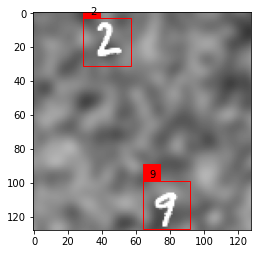

In [27]:
show_prediction(img, labels_true)

### Визуализация пропозалов

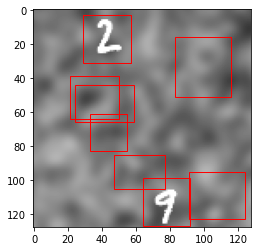

In [28]:
show_proposals(img, proposals_img)

### Визуализация детекций R-CNN

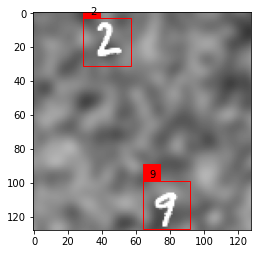

In [29]:
show_prediction(img, preds)